In [9]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_Pendulum_Invariance, get_SHM_Invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points, evaluate_model
from local_invariance_kernels import get_SHM_Local_Invariance, get_Pendulum_Local_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [30]:
mean = zero_mean(2)
time_step = 0.1
training_time = 5
testing_time = 5 

max_x = 150 
n_train = 3 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

test_starting_position = np.random.uniform(-max_x, max_x)
test_starting_velocity = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position)
print(train_starting_velocity)

print(test_starting_position)
print(test_starting_velocity)

data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
test_data = get_pendulum_data(time_step, testing_time, 1e-8, [test_starting_position], [test_starting_velocity])
for jitter in [2e-5]:
#    print("current jitter %s" %jitter)
    moi = get_GPR_model(get_MOI(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_model(moi, test_data, time_step)
    print(evaluate_moi[:2])
    for invar_density in [40]: #np.arange(10, 30, 10):
            try:
#                kernel = get_Pendulum_Local_Invariance(2, 40, jitter) #switch
                kernel = get_Pendulum_Invariance(3, invar_density, jitter) #switch
                m = get_GPR_model(kernel, mean, data, 100)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_model(m, test_data, time_step)
                print(evaluate_invariance[:2])

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 

# %%

158.89240985290257
3.760652268565508
1577, 
(8.172151690435721e-05, 7.381220420684372)
1609
(5.910215896185095e-05, 5.757094847701656)


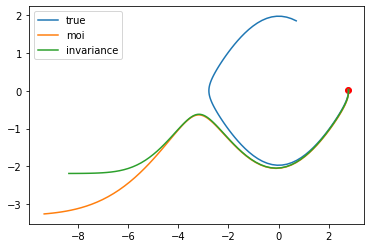

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(test_data[0][:,0],test_data[0][:,1], label="true")
plt.plot(evaluate_moi[2][:,0],evaluate_moi[2][:,1], label='moi')
plt.plot(evaluate_invariance[2][:,0],evaluate_invariance[2][:,1], label="invariance")
plt.scatter(test_data[0][0,0],test_data[0][0,1],color="red")
plt.legend()

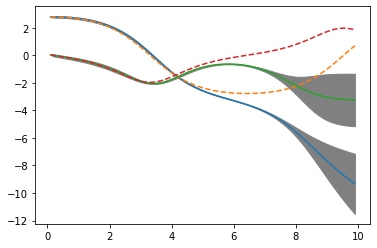

In [37]:
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
plt.plot(t,evaluate_moi[2][:,0])
plt.plot(t, test_data[0][:,0], '--')
plt.fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
plt.plot(t,evaluate_moi[2][:,1])
plt.plot(t, test_data[0][:,1], '--')
plt.fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")


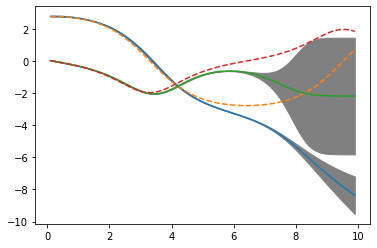

: 

In [38]:

plt.plot(t,evaluate_invariance[2][:,0])
plt.fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
plt.plot(t, test_data[0][:,0],'--')
plt.plot(t,evaluate_invariance[2][:,1])
plt.plot(t, test_data[0][:,1],'--')
plt.fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")